In [1]:
import glob
import os
import re
import sys
import warnings

from astropy import modeling
from astropy import units as u
from astropy.convolution import convolve, Gaussian2DKernel, convolve_fft
import astropy.io.fits as pyfits
from astropy.io import ascii
from astropy.nddata import CCDData
from astropy.stats import sigma_clip, sigma_clipped_stats, mad_std
from astropy.time import Time
from astropy.visualization import SqrtStretch, SinhStretch, MinMaxInterval, PercentileInterval, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS

import csv

import datetime

import math

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import cv2 as cv

import pandas as pd

import photutils as pt
from photutils import DAOStarFinder, find_peaks, aperture_photometry, CircularAperture

import random

from scipy import stats
import scipy.ndimage
import scipy.signal
import scipy.optimize as optimize

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(math.floor(n/10)%10!=1)*(n%10<4)*n%10::4])


In [2]:
# ignore overwriting reduced files warnings in case you need to rerun
warnings.filterwarnings('ignore', message='Overwriting existing file')

# ignore overflow errors
warnings.filterwarnings('ignore', message='overflow encountered in sinh')

# ignore everything, maybe don't do this?
warnings.filterwarnings('ignore')


### Tell me where your raw data is.

In [3]:
raw_data_direc = input ("Enter the directory where your data is stored: ")
test_direc = str(raw_data_direc)
print("The directory you entered is:", test_direc)


Enter the directory where your data is stored: /Users/Hannah/iraf/images/2019Q2UV02/Q2UV01/UT190505/
The directory you entered is: /Users/Hannah/iraf/images/2019Q2UV02/Q2UV01/UT190505/


### And what filter(s) you observed in.

In [4]:
filt_list = []

n_filt = input ("How many filters did you observe in? ")

for i in np.arange(int(n_filt)):
    filt = input ("Enter the {} filter you observed in: ".format(ordinal(i+1)))

    filt_list.append(str(filt))

for i in np.arange(int(n_filt)):
    if i == 0:
        print("The filters you entered are:")
        print(filt_list[i])
    else:
        print(filt_list[i])
        

How many filters did you observe in? 2
Enter the 1st filter you observed in: r
Enter the 2nd filter you observed in: i
The filters you entered are:
r
i


### Image Reduction -- Creates /reduced/cals/ and /reduced/data/ directories, and fills those directories with reduced calibration and science images.

In [5]:
cals_direc = os.path.join(raw_data_direc, 'reduced', 'cals')
reduced_direc = os.path.join(raw_data_direc, 'reduced', 'data')

# directories for reduced images
if not os.path.exists(cals_direc):
    os.makedirs(cals_direc)
if not os.path.exists(reduced_direc):
    os.makedirs(reduced_direc) 

# grab all files from the data directory; organize dataframe
files = sorted(glob.glob(os.path.join(raw_data_direc, "*.fits")))

df = pd.DataFrame(files,columns=['fname'])
df['objtype'] = pd.Series("", index=df.index)
df['filt'] = pd.Series("", index=df.index)
df['exp'] = pd.Series("", index=df.index)
df['epadu'] = pd.Series("", index=df.index)
df['objname'] = pd.Series("", index=df.index)

for ff,fname in enumerate(files):
    try:
        df['objtype'][ff] = pyfits.open(fname)[0].header['IMAGETYP']
        df['filt'][ff] = pyfits.open(fname)[0].header['FILTER']
        df['exp'][ff] = pyfits.open(fname)[0].header['EXPTIME']
        df['epadu'][ff] = pyfits.open(fname)[0].header['GTGAIN11']
        df['objname'][ff] = pyfits.open(fname)[0].header['OBJNAME']
    except IOError:
        print('\n File corrupt or missing: ' + fname)
        

#### Overscan correction

In [6]:
def trim_image(f, overscan_poly_order = 7):
    """
    trim_image returns a trimmed version of the raw image. The ARCTIC detector is structured in four quadrants which can be read out individually (Quad Mode) or as a whole (Lower Left Mode) and trim_image identifies which readout mode was used and crops the image accordingly.
        
    Parameters
    ----------
    f : raw fits image from ARCTIC
    overscan_poly_order : order of polynomial used to fit overscan
        
    Returns
    -------
    alldat : a list with [the image in a numpy array, the astropy header]
    """
    
    datfile = pyfits.getdata(f, header=True)
    dat_raw = datfile[0]
    dat_head = datfile[1]
    
    amp = pyfits.open(f)[0].header['READAMPS']
    
    if amp == "Quad":
        # ll, ul, lr, ur
        quads = ['DSEC11', 'DSEC21', 'DSEC12', 'DSEC22']
        biases = ['BSEC11', 'BSEC21', 'BSEC12', 'BSEC22']
        
        dat = [[],[],[],[]]
        for i,quad in enumerate(quads):
            idx_string = pyfits.open(f)[0].header[quad]
            idx = re.split('[: ,]',idx_string.rstrip(']').lstrip('['))
            dat[i] = dat_raw[int(idx[2])-1:int(idx[3]),int(idx[0])-1:int(idx[1])].astype(np.float64)
    
        over = [[],[],[],[]]
        avg_overscan = [[],[],[],[]]
        row_idx = [[],[],[],[]]
        p = [[],[],[],[]]
        fit_overscan = [[],[],[],[]]
        fit_overscan_col = [[],[],[],[]]
        
        for j,bias in enumerate(biases):
            idx_over_string = pyfits.open(f)[0].header[bias]
            idx_over = re.split('[: ,]',idx_over_string.rstrip(']').lstrip('['))
            over[j] = dat_raw[int(idx_over[2])-1:int(idx_over[3]),int(idx_over[0])-1:int(idx_over[1])]
            
            #Average along columns
            avg_overscan[j] = np.mean(over[j],axis=1)
            #Index array, then fit!
            row_idx[j] = np.arange(len(avg_overscan[j]))
            p[j] = np.polyfit(row_idx[j],avg_overscan[j],deg=overscan_poly_order)
            #Calculate array from fit, then transpose into a column
            fit_overscan[j] = np.poly1d(p[j])(row_idx[j])
            fit_overscan_col[j] = fit_overscan[j][:,np.newaxis]
        
        #Subtract column!
        dat[0] -= fit_overscan_col[0]
        dat[1] -= fit_overscan_col[1]
        dat[2] -= fit_overscan_col[2]
        dat[3] -= fit_overscan_col[3]
        
        sci_lo = np.concatenate((dat[2], dat[3]), axis = 1)
        sci_up = np.concatenate((dat[0], dat[1]), axis = 1)
        sci = np.concatenate((sci_up, sci_lo), axis = 0)

    if amp == 'LL':
        idx_string = pyfits.open(f)[0].header['DSEC11']
        idx = re.split('[: ,]',idx_string.rstrip(']').lstrip('['))
        sci = dat_raw[int(idx[2])-1:int(idx[3]),int(idx[0])-1:int(idx[1])].astype(np.float64)
    
        idx_over_string = pyfits.open(f)[0].header['BSEC11']
        idx_over = re.split('[: ,]',idx_over_string.rstrip(']').lstrip('['))
        over = dat_raw[int(idx_over[2])-1:int(idx_over[3]),int(idx_over[0])-1:int(idx_over[1])]
        
        #Average along columns
        avg_overscan = np.mean(over,axis=1)
        #Index array, then fit!
        row_idx = np.arange(len(avg_overscan))
        p = np.polyfit(row_idx,avg_overscan,deg=overscan_poly_order)
        #Calculate array from fit, then transpose into a column
        fit_overscan = np.poly1d(p)(row_idx)
        fit_overscan_col = fit_overscan[:,np.newaxis]
        #Subtract column!
        sci -= fit_overscan_col
    
    alldat = [sci,dat_head]
    return alldat


#### Scale darks

In [7]:
def getdark(expt):
    """
    Generate a dark given an exposure time or scale down from longest dark available
        
    Parameters
    ----------
    expt : exposure time (in the data frame: df['exp'])
        
    Returns
    -------
    dark : dark image for that exposure time (numpy array)
    """
    
    try:
        dark = pyfits.getdata(os.path.join(cals_direc,'master_dark_{0}.fits'.format(expt)))
    except IOError:
        scaleto = np.max(df['exp'][df['exp'] != ''])
        dark = pyfits.getdata(os.path.join(cals_direc,'master_dark_{0}.fits'.format(scaleto)))
        dark *= (expt/scaleto)
    return dark


#### Bias combine


 >>> Starting bias combine...
   > Created master bias


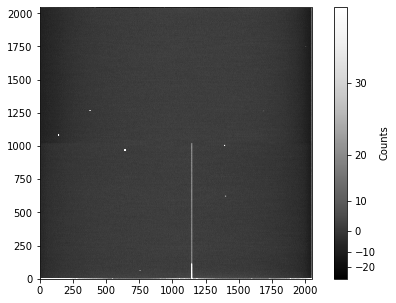

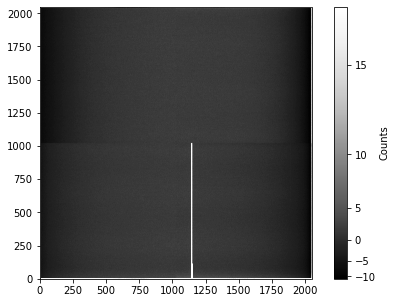

In [8]:
### CREATE MASTER BIAS #######################################

print('\n >>> Starting bias combine...')

bias_idx = df[df['objtype'] == 'Bias'].index.tolist()

if len(bias_idx) == 0:
    print('   > No biases found. Continuing reductions...')
    bias=0.
else:
    biases = np.array([trim_image(df['fname'][n])[0] for n in bias_idx])
    bias = np.median(biases,axis=0)
    pyfits.writeto(os.path.join(cals_direc, 'master_bias.fits'),bias,overwrite=True)
    print('   > Created master bias')
    
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1, 1, 1)
norm = ImageNormalize(biases[1],
                      interval=ZScaleInterval(),
                      stretch=SinhStretch())
im = ax.imshow(biases[0], cmap='Greys_r', origin='lower', norm=norm)
fig.colorbar(im, label='Counts')
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1, 1, 1)
norm = ImageNormalize(bias,
                      interval=ZScaleInterval(),
                      stretch=SinhStretch())
im = ax.imshow(bias, cmap='Greys_r', origin='lower', norm=norm)
fig.colorbar(im, label='Counts')
plt.show()


#### Dark combine

In [9]:
bias_sub = input ("Is your dark exposure time much longer (10x) than the exposure time of your science images? (type Yes or No): ")


Is your dark exposure time much longer (10x) than the exposure time of your science images? (type Yes or No): No



 >>> Starting darks...
   > Created master 120.0 second dark
   > No darks found for exposure time 2.0 sec. Continuing reductions...
   > No darks found for exposure time 4.0 sec. Continuing reductions...
   > No darks found for exposure time 40.0 sec. Continuing reductions...
   > No darks found for exposure time 60.0 sec. Continuing reductions...
   > No darks found for exposure time 90.0 sec. Continuing reductions...


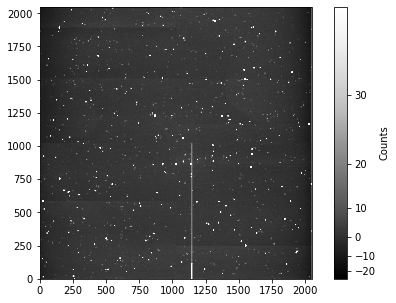

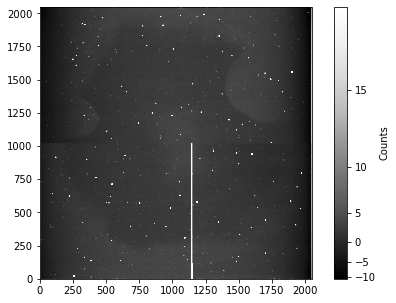

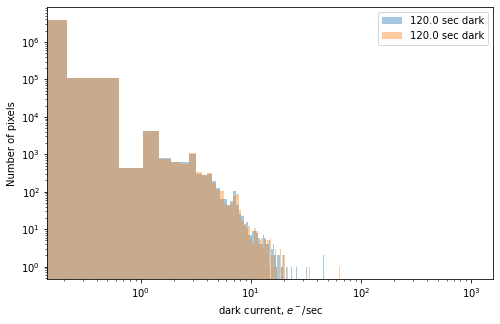

In [17]:
### CREATE MASTER DARKS ######################################
### these are bias subtracted

# array of all exposure times found
times = list(filter(None,pd.unique(df.exp.ravel())))

print('\n >>> Starting darks...')

for ii in range(0,len(times)):
    dark_idx = df[(df['exp'] == times[ii]) & (df['objtype'] == 'Dark')].index.tolist()
    
    if len(dark_idx) == 0:
        print('   > No darks found for exposure time ' + str(times[ii]) + ' sec. Continuing reductions...')
    else:
        if bias_sub == "Yes":
            dark_idx_1 = random.choice([i for i in range(0, len(dark_idx))])
            dark_idx_2 = random.choice([i for i in range(0, len(dark_idx)) if i not in [dark_idx_1]])

        
            dark_1 = np.array([trim_image(df['fname'][n])[0] for n in [dark_idx_1]]) - bias
            dark_1 = sigma_clip(dark_1, sigma_lower=5, sigma_upper=5, axis=0, masked=False)
            dark_1_exp = times[ii]
            
            dark_2 = np.array([trim_image(df['fname'][n])[0] for n in [dark_idx_2]]) - bias
            dark_2 = sigma_clip(dark_2, sigma_lower=5, sigma_upper=5, axis=0, masked=False)
            dark_2_exp = times[ii]
        
            darks = np.array([trim_image(df['fname'][n])[0] for n in dark_idx]) - bias
            darks = sigma_clip(darks, sigma_lower=5, sigma_upper=5, axis=0, masked=False)
            dark_final = np.median(darks,axis=0)
            
        if bias_sub == "No":
            dark_idx_1 = random.choice([i for i in range(0, len(dark_idx))])
            dark_idx_2 = random.choice([i for i in range(0, len(dark_idx)) if i not in [dark_idx_1]])

        
            dark_1 = np.array([trim_image(df['fname'][n])[0] for n in [dark_idx_1]])
            dark_1 = sigma_clip(dark_1, sigma_lower=5, sigma_upper=5, axis=0, masked=False)
            dark_1_exp = times[ii]
            
            dark_2 = np.array([trim_image(df['fname'][n])[0] for n in [dark_idx_2]])
            dark_2 = sigma_clip(dark_2, sigma_lower=5, sigma_upper=5, axis=0, masked=False)
            dark_2_exp = times[ii]
        
            darks = np.array([trim_image(df['fname'][n])[0] for n in dark_idx])
            darks = sigma_clip(darks, sigma_lower=5, sigma_upper=5, axis=0, masked=False)
            dark_final = np.median(darks,axis=0)
        
        name = os.path.join(cals_direc,'master_dark_{0}.fits'.format(times[ii]))
        pyfits.writeto(name,dark_final,overwrite=True)
        print('   > Created master '+ str(times[ii])+' second dark')
        
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1, 1, 1)
norm = ImageNormalize(darks[0],
                      interval=ZScaleInterval(),
                      stretch=SinhStretch())
im = ax.imshow(darks[0], cmap='Greys_r', origin='lower', norm=norm)
fig.colorbar(im, label='Counts')
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1, 1, 1)
norm = ImageNormalize(dark_final,
                      interval=ZScaleInterval(),
                      stretch=SinhStretch())
im = ax.imshow(dark_final, cmap='Greys_r', origin='lower', norm=norm)
fig.colorbar(im, label='Counts')
plt.show()

plt.figure(figsize=(8, 5))

dark_1 = dark_1 * df['epadu'][dark_idx_1] / dark_1_exp
dark_2 = dark_2 * df['epadu'][dark_idx_2] / dark_2_exp

plt.hist(dark_1.flatten(), bins=2500, density=False, label='%.1f sec dark' % dark_1_exp, alpha=0.4)
plt.hist(dark_2.flatten(), bins=2500, density=False, label='%.1f sec dark' % dark_2_exp, alpha=0.4)
plt.xlabel('dark current, $e^-$/sec')
plt.ylabel('Number of pixels')
plt.loglog()
plt.legend()
plt.show()


Based on the histogram above, what is the minimum dark current you want to consider for a hot pixel: 2


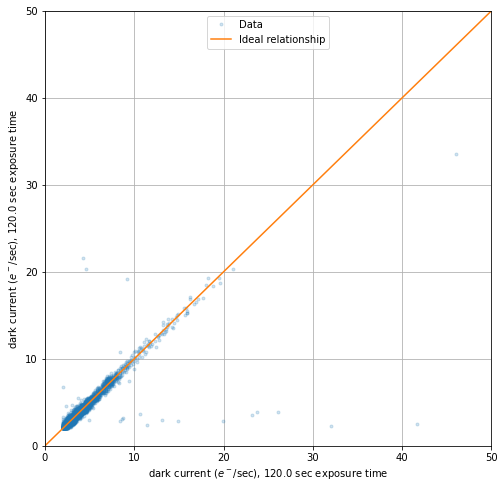

In [18]:
min_dark = input ("Based on the histogram above, what is the minimum dark current you want to consider for a hot pixel: ")

hot_pixels = (dark_1 > float(min_dark)) & (dark_2 > float(min_dark))

plt.figure(figsize=(8, 8))
plt.plot(dark_1[hot_pixels].flatten(), dark_2[hot_pixels].flatten(), '.', alpha=0.2, label='Data')
plt.xlabel("dark current ($e^-$/sec), %.1f sec exposure time" % dark_1_exp)
plt.xlim(0,50)
plt.ylabel("dark current ($e^-$/sec), %.1f sec exposure time" % dark_2_exp)
plt.ylim(0,50)
plt.plot([0, 100], [0, 100], label='Ideal relationship')
plt.grid()
plt.legend()
plt.show()


Based on the 1-to-1 plot above, what is the cutoff, above which a pixel in the dark will be named a 'hot pixel': 10


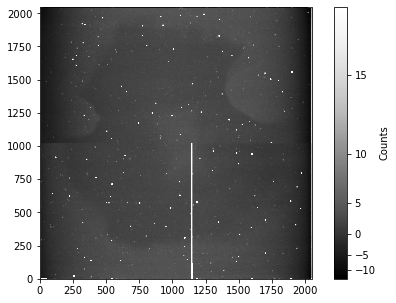

In [19]:
max_dark = input ("Based on the 1-to-1 plot above, what is the cutoff, "
                  "above which a pixel in the dark will be named a 'hot pixel': ")

bad_hot_pixels = (dark_1 > float(max_dark)) & (dark_2 > float(max_dark))

dark_final_mask = np.ma.array(dark_final, mask=bad_hot_pixels)
dark_final_mask = dark_final_mask.filled(np.nan)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1, 1, 1)
norm = ImageNormalize(dark_final_mask,
                      interval=ZScaleInterval(),
                      stretch=SinhStretch())
im = ax.imshow(dark_final_mask, cmap='Greys_r', origin='lower', norm=norm)
fig.colorbar(im, label='Counts')
plt.show()


#### Flat combine (multiple filters)

In [722]:
def ccdmask(ratio, ncmed=7, nlmed=7, ncsig=15, nlsig=15, 
            lsigma=9, hsigma=9, ngood=5):
    """
    Uses method based on the IRAF ccdmask task to generate a mask based on the
    given input.

    .. note::
        This function uses ``lines`` as synonym for the first axis and
        ``columns`` the second axis. Only two-dimensional ``ratio`` is
        currently supported.

    Parameters
    ----------
    ratio : `~astropy.nddata.CCDData`
        Data to used to form mask.  Typically this is the ratio of two flat
        field images.

    findbadcolumns : `bool`, optional
        If set to True, the code will search for bad column sections.  Note
        that this treats columns as special and breaks symmetry between lines
        and columns and so is likely only appropriate for detectors which have
        readout directions.
        Default is ``False``.

    byblocks : `bool`, optional
        If set to true, the code will divide the image up in to blocks of size
        nlsig by ncsig and determine the standard deviation estimate in each
        block (as described in the original IRAF task, see Notes below).  If
        set to False, then the code will use `scipy.ndimage.percentile_filter`
        to generate a running box version of the standard
        deviation estimate and use that value for the standard deviation at
        each pixel.
        Default is ``False``.

    ncmed, nlmed : `int`, optional
        The column and line size of the moving median rectangle used to
        estimate the uncontaminated local signal. The column median size should
        be at least 3 pixels to span single bad columns.
        Default is ``7``.

    ncsig, nlsig : `int`, optional
        The column and line size of regions used to estimate the uncontaminated
        local sigma using a percentile. The size of the box should contain of
        order 100 pixels or more.
        Default is ``15``.

    lsigma, hsigma : `float`, optional
        Positive sigma factors to use for selecting pixels below and above the
        median level based on the local percentile sigma.
        Default is ``9``.

    ngood : `int`, optional
        Gaps of undetected pixels along the column direction of length less
        than this amount are also flagged as bad pixels, if they are between
        pixels masked in that column.
        Default is ``5``.

    Returns
    -------
    mask : `numpy.ndarray`
        A boolean ndarray where the bad pixels have a value of 1 (True) and
        valid pixels 0 (False), following the numpy.ma conventions.

    Notes
    -----
    Similar implementation to IRAF's ccdmask task.
    The Following documentation is copied directly from:
    http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?ccdmask

    The input image is first subtracted by a moving box median. The median is
    unaffected by bad pixels provided the median size is larger that twice the
    size of a bad region. Thus, if 3 pixel wide bad columns are present then
    the column median box size should be at least 7 pixels. The median box can
    be a single pixel wide along one dimension if needed. This may be
    appropriate for spectroscopic long slit data.

    The median subtracted image is then divided into blocks of size nclsig by
    nlsig. In each block the pixel values are sorted and the pixels nearest the
    30.9 and 69.1 percentile points are found; this would be the one sigma
    points in a Gaussian noise distribution. The difference between the two
    count levels divided by two is then the local sigma estimate. This
    algorithm is used to avoid contamination by the bad pixel values. The block
    size must be at least 10 pixels in each dimension to provide sufficient
    pixels for a good estimate of the percentile sigma. The sigma uncertainty
    estimate of each pixel in the image is then the sigma from the nearest
    block.

    The deviant pixels are found by comparing the median subtracted residual to
    a specified sigma threshold factor times the local sigma above and below
    zero (the lsigma and hsigma parameters). This is done for individual pixels
    and then for column sums of pixels (excluding previously flagged bad
    pixels) from two to the number of lines in the image. The sigma of the sums
    is scaled by the square root of the number of pixels summed so that
    statistically low or high column regions may be detected even though
    individual pixels may not be statistically deviant. For the purpose of this
    task one would normally select large sigma threshold factors such as six or
    greater to detect only true bad pixels and not the extremes of the noise
    distribution.

    As a final step each column is examined to see if there are small segments
    of unflagged pixels between bad pixels. If the length of a segment is less
    than that given by the ngood parameter all the pixels in the segment are
    also marked as bad.
    """
    try:
        nlines, ncols = ratio.data.shape
    except (TypeError, ValueError):
        # shape is not iterable or has more or less than two values
        raise ValueError('"ratio" must be two-dimensional.')
    except AttributeError:
        # No data attribute or data has no shape attribute.
        raise ValueError('"ratio" should be a "CCDData".')

    def _sigma_mask(baseline, one_sigma_value, lower_sigma, upper_sigma):
        """Helper function to mask values outside of the specified sigma range.
        """
        return ((baseline < -lower_sigma * one_sigma_value) |
                (baseline > upper_sigma * one_sigma_value))

    mask = ~np.isfinite(ratio.data)
    medsub = (ratio.data -
              scipy.ndimage.median_filter(ratio.data, size=(nlmed, ncmed)))

    high = scipy.ndimage.percentile_filter(medsub, 69.1, size=(nlsig, ncsig))
    low = scipy.ndimage.percentile_filter(medsub, 30.9, size=(nlsig, ncsig))
    sigmas = (high - low) / 2.0
    mask |= _sigma_mask(medsub, sigmas, lsigma, hsigma)

    return mask


 >>> Starting flats...
   > Exposure time 2.0 sec. No dark correction neccessary.


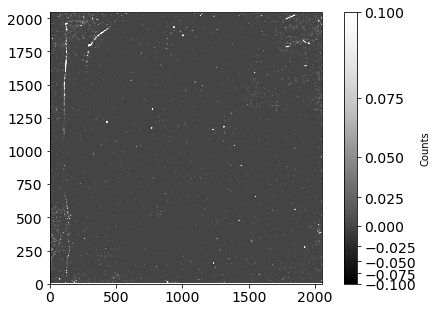

   > Created master r flat


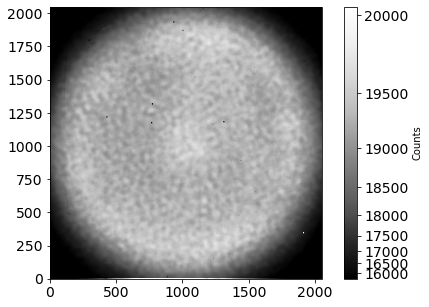

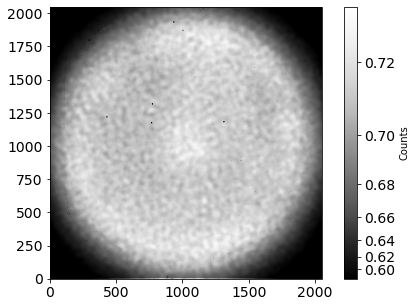

   > Exposure time 2.0 sec. No dark correction neccessary.


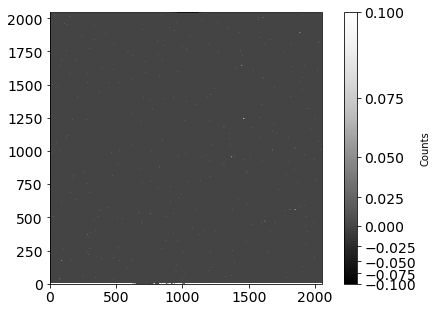

   > Created master i flat


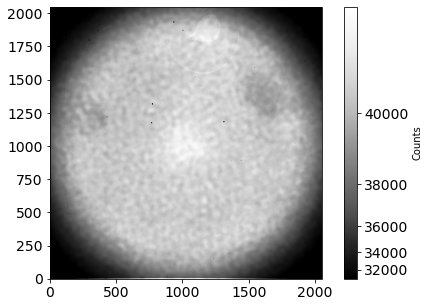

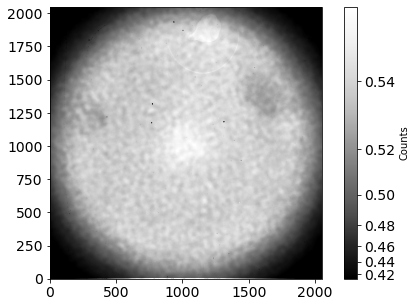

In [724]:
### CREATE MASTER FLATS ######################################
### these are bias and dark subtracted, then normalized

flat_mask_list = []

# array of all filters found
filters = list(filter(None,pd.unique(df.filt.ravel())))

print('\n >>> Starting flats...')

for ii in range(0,len(filters)):
    flat_idx = df[(df['filt'] == filters[ii]) & (df['objtype'] == 'Flat')].index.tolist()
    
    if len(flat_idx) == 0:
        print('   > No flats found for the ' + str(filters[ii]) + ' filter. Continuing reductions...')
    else:
        # get the correct master dark. if not exact exp time, scale it
        # from the longest dark frame. if no darks at all, continue.
        expt = df['exp'][flat_idx[0]]
        if expt > 60.0:
            try:
                dark = getdark(expt)
            except IOError:
                print('   > No darks found for exposure time ' + str(expt) + ' sec. Continuing reductions...')
                dark = 0.
        else:
            print('   > Exposure time ' + str(expt) + ' sec. No dark correction neccessary.')
            dark = 0.
            
        flat_idx_1 = flat_idx[0]
        flat_idx_2 = flat_idx[-1]
        
        if bias_sub == "Yes":
            flat_1 = np.array([trim_image(df['fname'][n])[0] for n in [flat_idx_1]]) - bias - dark
            flat_1 = sigma_clip(flat_1, sigma_lower=5, sigma_upper=5, axis=0, masked=False)
            flat_2 = np.array([trim_image(df['fname'][n])[0] for n in [flat_idx_2]]) - bias - dark
            flat_2 = sigma_clip(flat_2, sigma_lower=5, sigma_upper=5, axis=0, masked=False)
        
            ratio = flat_2/flat_1
            if ratio.mean() > 0.95:
                flat_mask = ccdmask(flat_2[0])
            else:
                flat_mask = ccdmask(ratio[0])

            fig = plt.figure(figsize=(8,5))
            ax = fig.add_subplot(1, 1, 1)
            norm = ImageNormalize(flat_mask,
                                  interval=ZScaleInterval(),
                                  stretch=SinhStretch())
            im = ax.imshow(flat_mask, cmap='Greys_r', origin='lower', norm=norm)
            fig.colorbar(im, label='Counts')
            plt.show()
        
            flat_mask_list.append(flat_mask)
        

            flats = np.array([trim_image(df['fname'][n])[0] for n in flat_idx]) - bias - dark
            flat_final = np.median(flats,axis=0)
            flat_final /= np.max(flat_final)
            
        if bias_sub == "No":
            flat_1 = np.array([trim_image(df['fname'][n])[0] for n in [flat_idx_1]]) - dark
            flat_1 = sigma_clip(flat_1, sigma_lower=5, sigma_upper=5, axis=0, masked=False)
            flat_2 = np.array([trim_image(df['fname'][n])[0] for n in [flat_idx_2]]) - dark
            flat_2 = sigma_clip(flat_2, sigma_lower=5, sigma_upper=5, axis=0, masked=False)
        
            ratio = flat_2/flat_1
            if ratio.mean() > 0.95:
                flat_mask = ccdmask(flat_2[0])
            else:
                flat_mask = ccdmask(ratio[0])

            fig = plt.figure(figsize=(8,5))
            ax = fig.add_subplot(1, 1, 1)
            norm = ImageNormalize(flat_mask,
                                  interval=ZScaleInterval(),
                                  stretch=SinhStretch())
            im = ax.imshow(flat_mask, cmap='Greys_r', origin='lower', norm=norm)
            fig.colorbar(im, label='Counts')
            plt.show()
        
            flat_mask_list.append(flat_mask)
        

            flats = np.array([trim_image(df['fname'][n])[0] for n in flat_idx]) - dark
            flat_final = np.median(flats,axis=0)
            flat_final /= np.max(flat_final)

        new_filter_name = filters[ii].strip("#2")
        filts = new_filter_name[-1]
        name = os.path.join(cals_direc, 'master_flat_{0}.fits'.format(filts))
        pyfits.writeto(name,flat_final,overwrite=True)
        print('   > Created master '+ str(new_filter_name[-1])+' flat')
        
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(1, 1, 1)
        norm = ImageNormalize(flats[0],
                              interval=ZScaleInterval(),
                              stretch=SinhStretch())
        im = ax.imshow(flats[0], cmap='Greys_r', origin='lower', norm=norm)
        fig.colorbar(im, label='Counts')
        plt.show()

        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(1, 1, 1)
        norm = ImageNormalize(flat_final,
                              interval=ZScaleInterval(),
                              stretch=SinhStretch())
        im = ax.imshow(flat_final, cmap='Greys_r', origin='lower', norm=norm)
        fig.colorbar(im, label='Counts')
        plt.show()
                

#### Dark, bias, and flat correct science images

In [725]:
def fixpix(data, badmask, n=5, retdat=True):
    """Replace pixels flagged as nonzero in a bad-pixel mask with the
    average of their nearest four good neighboring pixels.

    :INPUTS:
      data : numpy array (two-dimensional)

      badmask : numpy array (same shape as data)

    :OPTIONAL_INPUTS:
      n : int
        number of nearby, good pixels to average over

      retdat : bool
        If True, return an array instead of replacing-in-place and do
        _not_ modify input array `data`.  This is always True if a 1D
        array is input!

    :RETURNS: 
      another numpy array (if retdat is True)

    :TO_DO:
      Implement new approach of Popowicz+2013 (http://arxiv.org/abs/1309.4224)
    """
    # 2010-09-02 11:40 IJC: Created
    #2012-04-05 14:12 IJMC: Added retdat option
    # 2012-04-06 18:51 IJMC: Added a kludgey way to work for 1D inputs
    # 2012-08-09 11:39 IJMC: Now the 'n' option actually works.
    

    if data.ndim==1:
        data = np.tile(data, (3,1))
        badmask = np.tile(badmask, (3,1))
        ret = fixpix(data, badmask, n=2, retdat=True)
        return ret[1]


    nx, ny = data.shape

    badx, bady = np.nonzero(badmask)
    nbad = len(badx)

    if retdat:
        data = np.array(data, copy=True)
    
    for ii in range(nbad):
        thisloc = badx[ii], bady[ii]
        rad = 0
        numNearbyGoodPixels = 0

        while numNearbyGoodPixels<n:
            rad += 1
            xmin = max(0, badx[ii]-rad)
            xmax = min(nx, badx[ii]+rad)
            ymin = max(0, bady[ii]-rad)
            ymax = min(ny, bady[ii]+rad)
            x = np.arange(nx)[xmin:xmax+1]
            y = np.arange(ny)[ymin:ymax+1]
            yy,xx = np.meshgrid(y,x)
            #print ii, rad, xmin, xmax, ymin, ymax, badmask.shape
            
            rr = abs(xx + 1j*yy) * (1. - badmask[xmin:xmax+1,ymin:ymax+1])
            numNearbyGoodPixels = (rr>0).sum()
        
        closestDistances = np.unique(np.sort(rr[rr>0])[0:n])
        numDistances = len(closestDistances)
        localSum = 0.
        localDenominator = 0.
        for jj in range(numDistances):
            localSum += data[xmin:xmax+1,ymin:ymax+1][rr==closestDistances[jj]].sum()
            localDenominator += (rr==closestDistances[jj]).sum()

        #print badx[ii], bady[ii], 1.0 * localSum / localDenominator, data[xmin:xmax+1,ymin:ymax+1]
        data[badx[ii], bady[ii]] = 1.0 * localSum / localDenominator

    if retdat:
        ret = data
    else:
        ret = None

    return ret


 >>> 70 science images found. Starting reductions...


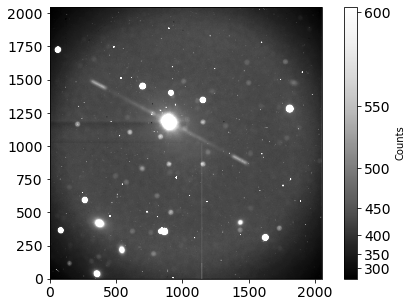

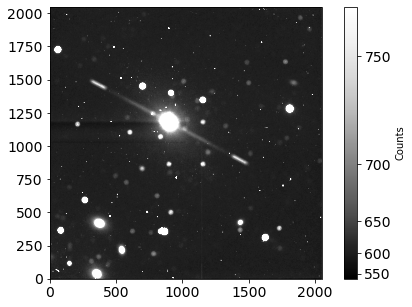

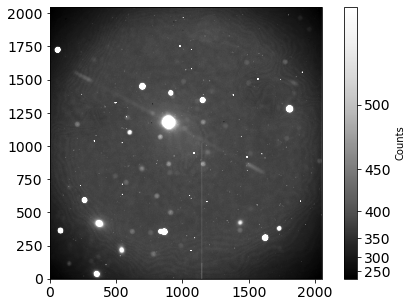

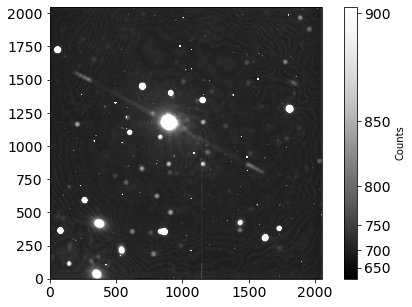

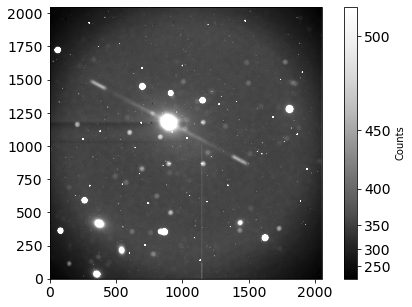

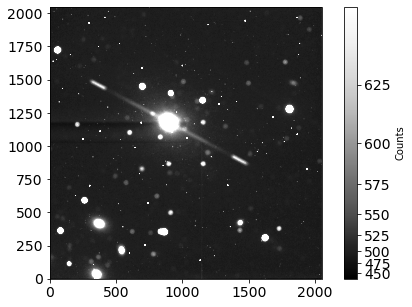

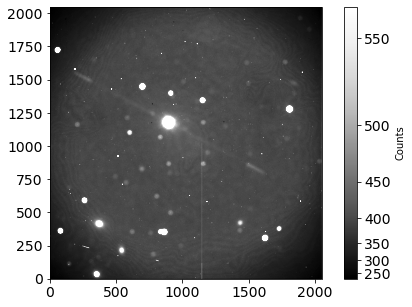

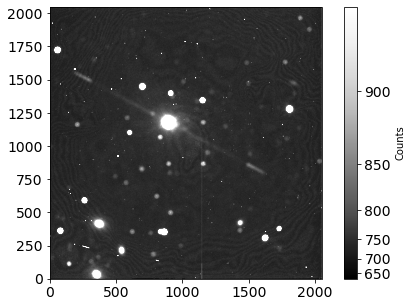

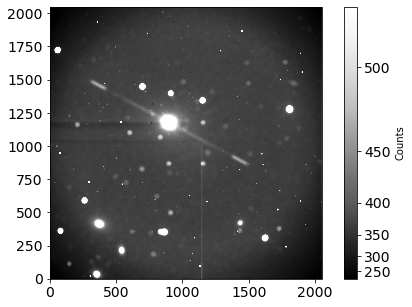

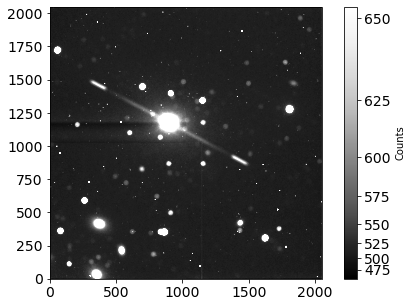


 >>> Finished reductions!


In [729]:
### REDUCE SCIENCE IMAGES ####################################
### (raw - dark) / masterflat

dat_idx = df[df['objtype'] == 'Object'].index.tolist()

print('\n >>> '+str(len(dat_idx))+' science images found. Starting reductions...')
for n in dat_idx:
    datfile = trim_image(df['fname'][n])
    dat_raw = datfile[0]
    dat_head = datfile[1]
    
    time = df['exp'][n]
    if time > 30.0:
        try:
            dark = getdark(time)
        except IOError:
            print('   > No darks found for exposure time ' + str(time) + ' sec. Continuing reductions...')
            dark = 0.
    else:
        print('   > Exposure time ' + str(time) + ' sec. No dark correction necessary.')
        dark = 0.

    new_filter_name = df['filt'][n].strip("#2")
    filt = new_filter_name[-1]
    try:
        flat = flat = pyfits.getdata(os.path.join(cals_direc,'master_flat_{0}.fits'.format(filt)))
    except IOError:
        print('   > Warning! No ' + str(new_filter_name) + ' filter flat found for ' + df['fname'][n])
        flat = 1. 
        
    combined_mask = flat_mask_list[filt_list.index(filt)] #bad_hot_pixels | 
        
    if bias_sub == "Yes":
        dat = (dat_raw - dark - bias) / flat
        
        dat = fixpix(dat, combined_mask)
        

    if bias_sub == "No":
        dat = (dat_raw - dark) / flat
        
        dat = fixpix(dat, combined_mask)
        
    name = os.path.join(reduced_direc,'red_{0}'.format(os.path.basename(df['fname'][n])))
    pyfits.writeto(name,dat,overwrite=True,header=dat_head)
    
    if n % 15 == 0:
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(1, 1, 1)
        norm = ImageNormalize(dat_raw,
                              interval=ZScaleInterval(),
                              stretch=SinhStretch())
        im = ax.imshow(dat_raw, cmap='Greys_r', origin='lower', norm=norm)
        fig.colorbar(im, label='Counts')
        plt.show()

        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(1, 1, 1)
        norm = ImageNormalize(dat,
                              interval=ZScaleInterval(),
                              stretch=SinhStretch())
        im = ax.imshow(dat, cmap='Greys_r', origin='lower', norm=norm)
        fig.colorbar(im, label='Counts')
        plt.show()

print('\n >>> Finished reductions!')

### Photometry -- Performs aperture photometry on science images in the /reduced/data/ directory for multiple filters.

In [730]:
cals_direc = os.path.join(raw_data_direc, 'reduced', 'cals')
reduced_direc = os.path.join(raw_data_direc, 'reduced', 'data')
results_direc = os.path.join(reduced_direc, 'results')

# directories for reduced images
if not os.path.exists(cals_direc):
    print('   > Reduced cals directory does not exist! Run cells above (Image Reduction section) first.')
if not os.path.exists(reduced_direc):
    print('   > Reduced data directory does not exist! Run cells above (Image Reduction section) first.')
if not os.path.exists(results_direc):
    os.makedirs(results_direc)
    
red_files = sorted(glob.glob(os.path.join(reduced_direc, "*.fits")))
    

#### Find peak of Gaussian

In [731]:
def update_coords(img, x_guess, y_guess, mask_max_counts=65000, box_width=70, plot_fit=False, smooth=True, kernel_size=10.):
    
    '''
    img: 2D array. Should be the image you are analyzing
        x_guess: int, 1st guess for the x coordinate. Needs to be closer than box_width
        y_guess: int, 1st guess for the y coordinate. Needs to be closer than box_width
        mask_max_counts: Set all points with counts higher than this number equal to the median
        box_width: int,  The area to consider for the stars coordinates. Needs to be small enough to not include
            extra stars, but big enough not to include errors on your x,y guess
    plot_fit: bool, show a plot to the gauss fit?
        smooth: bool, convolve image with gaussian first? The advantage of this is that it will take out some
            of the errors caused by the image being a donut instead of a gaussian. Especially useful for
            non-uniform PSFs, such as ARCSAT's defocused image. For ARCTIC, this may not be necessary.
            Try it anyway though!
        kernel_size: float, standard deviation of gaussian kernel used to smooth data (pixels). Irrevelvant
            if smooth is set to False
    '''
    box_size = int(box_width/2)
    
    x_guess = int(x_guess)
    y_guess=int(y_guess)
    # cutout the part of the image around the star of interest
    stamp = img[y_guess-box_size:y_guess+box_size,x_guess-box_size:x_guess+box_size ].astype(np.float64)
    cutout = np.copy(stamp)

    # change saturated pixels to 0, so it doesn't throw off fit
    cutout[cutout>mask_max_counts] = 0.

    if smooth:
        # Convolve image with gaussian kernel to limit the noise
        gauss_kernel = Gaussian2DKernel(kernel_size)
        cutout = convolve(cutout, gauss_kernel, boundary='extend')
    else:
        cutout_s = cutout
        # Subtract sky background
    cutout -= np.median(cutout)
    
    # Sum pixels in x,y directions
    x_sum = np.sum(cutout, axis=0)
    y_sum = np.sum(cutout, axis=1)
    
    # Fit a gaussian to the x and y summed columns
    offset = np.arange(box_width)-box_size
    fitter = modeling.fitting.LevMarLSQFitter()
    model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
    fitted_x = fitter(model, offset, x_sum)
    fitted_y = fitter(model, offset, y_sum)
    
    # Add the offset from the fitted gaussian to the original guess
    
    x_cen = x_guess + fitted_x.mean
    y_cen = y_guess + fitted_y.mean
    x_diff = x_cen - x_guess
    y_diff = y_cen - y_guess

    #print("X Guess : %.2f ; X Corrected To : %.2f ; Difference Of : %.2f" % (x_guess, x_cen, x_diff))
    #print("Y Guess : %.2f ; Y Corrected To : %.2f ; Difference Of : %.2f" % (y_guess, y_cen, y_diff))

    if plot_fit:
    
        f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    
        ax1.plot(offset, x_sum, 'o', color='C0', label='x offset')
        ax1.plot(offset, y_sum, 'o', color='C1', label='y offset')
    
        ax1.plot(offset, fitted_x(offset), 'C0')
        ax1.plot(offset, fitted_y(offset), 'C1')
    
        ax1.legend()
    
        m,s = np.median(stamp), np.std(stamp)
        ax2.imshow(stamp, vmin=m-s, vmax=m+s, origin='lower', cmap='Greys_r', interpolation='nearest',
        extent=[-box_size,box_size,-box_size,box_size])
        ax2.plot(fitted_x.mean, fitted_y.mean, 'ro', label='updated')
        ax2.plot(0,0, 'bo', label='guess')
        ax2.legend()
    
        ax3.imshow(img, vmin=m-s, vmax=m+s, origin='lower', cmap='Greys_r', interpolation='nearest',)
        ax3.plot(x_cen, y_cen, 'ro', markersize=1)
        ax3.plot(x_guess, y_guess, 'bo', markersize=1)
    
        plt.tight_layout()
        plt.savefig(os.path.join(results_direc,str(img[-8])+'.pos.png'))
        plt.close()
        plt.close()
        plt.close()
        
    return x_cen, y_cen
        

### Tell me where (x,y position) your star of interest is (i.e., the star with an eclipsing body) in your science images.

In [748]:
x_list, y_list = [],[]

exopl_x = input ("Enter the x position of your star of interest: ")
exopl_y = input ("Enter the y position of your star of interest: ")

x_list.append(float(exopl_x))
y_list.append(float(exopl_y))
print("The position you entered is:", x_list[0], ",", y_list[0])

Enter the x position of your star of interest: 696
Enter the y position of your star of interest: 1452
The position you entered is: 696.0 , 1452.0


### Tell me the other x,y positions of your references stars.

In [749]:
n_ref = input ("How many reference stars do you have? ")

for i in np.arange(int(n_ref)):
    ref_x = input ("Enter the x position of your {} reference star: ".format(ordinal(i+1)))
    ref_y = input ("Enter the y position of your {} reference star: ".format(ordinal(i+1)))

    x_list.append(float(ref_x))
    y_list.append(float(ref_y))

for i in np.arange(int(n_ref)+1):
    if i == 0:
        print("The positions you entered are:")
        print(x_list[i], ",", y_list[i])
    else:
        print(x_list[i], ",", y_list[i])

How many reference stars do you have? 2
Enter the x position of your 1st reference star: 1153
Enter the y position of your 1st reference star: 1345
Enter the x position of your 2nd reference star: 1806
Enter the y position of your 2nd reference star: 1281
The positions you entered are:
696.0 , 1452.0
1153.0 , 1345.0
1806.0 , 1281.0


#### Create .mag files containing raw fluxes of stars

In [750]:
print('\n >>> Starting daofind...')

for ff,fname in enumerate(red_files):
    hdul = pyfits.open(fname)
    header = hdul[0].header
    wcs = WCS(header)
    filt = hdul[0].header['FILTER']
    image = hdul[0].data
            
    results = xpos, ypos = [], []
    for i,xs in enumerate(x_list):
            x, y = xs, y_list[i]
            
            x, y = update_coords(image, x, y, box_width=70)
            
            xpos.append(float(x))
            ypos.append(float(y))
                
    refs = [(x,y) for x,y in zip(xpos,ypos)]
    ap_radii = 37.0
    an_r_in = 40.0
    an_r_out = 45.0
    plot_apertures = CircularAperture(refs, r=ap_radii)
    plot_annulus_in = CircularAperture(refs, r=an_r_in)
    plot_annulus_out = CircularAperture(refs, r=an_r_out)

    _, new_fname = os.path.split(fname)
    new_fname = os.path.splitext(new_fname)[0]
    
    if ff % 15 == 0:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        norm = ImageNormalize(image, interval=ZScaleInterval(), stretch=SinhStretch())
        im = ax.imshow(image, cmap='Greys_r', origin='lower', norm=norm)
        plot_annulus_out.plot(color='r', lw=1.0, alpha=0.5)
        fig.colorbar(im, label='Counts')
        plt.tight_layout()
        plt.savefig(os.path.join(results_direc,str(new_fname)+'.coor.png'))
        plt.close()
    
    filt = filt[-1]

    for r in refs:
        if np.isnan(r).any():
            print('Make sure you remove the file!', fname)
            break
        else:
            """
            Get magnitudes of sources
            """
            
            new_fname_mag = str(new_fname)+'.mag'
            new_fname_mag = open(os.path.join(results_direc,new_fname_mag),'w+')

            aperture = pt.CircularAperture(refs, r=ap_radii)
            new_fname_mag.write('aperture_area \t {} \n'.format(aperture.area))
            
            annulus_aperture = pt.CircularAnnulus(refs, r_in=an_r_in, r_out=an_r_out)
            new_fname_mag.write('annulus_area \t {} \n'.format(annulus_aperture.area))
            
            annulus_masks = annulus_aperture.to_mask(method='exact')
            #plt.imshow(annulus_masks[0])
            #plt.colorbar()
            #plt.show()
            
            bkg_median = []
            
            for mask in annulus_masks:
                annulus_data = mask.multiply(image)
                #norm = ImageNormalize(annulus_data, interval=ZScaleInterval(), stretch=SinhStretch())
                #plt.imshow(annulus_data)
                #plt.colorbar()
                #plt.show()
                
                annulus_data_1d = annulus_data[mask.data > 0.0]
                _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
                bkg_median.append(median_sigclip)
            
            bkg_median = np.array(bkg_median)
        
            new_fname_mag.write('# \n')
                        
            phot_table = pt.aperture_photometry(image, aperture, method='exact')
            phot_table['annulus_median'] = bkg_median
            phot_table['aper_bkg'] = bkg_median * aperture.area
            phot_table['aper_sum_bkgsub'] = phot_table['aperture_sum'] - phot_table['aper_bkg']
            
            ascii.write(phot_table, new_fname_mag, delimiter='\t')



 >>> Starting daofind...


### Magnitudes -- Converts raw photometry to instrumental magnitudes.

In [751]:
results_direc = os.path.join(reduced_direc, 'results')

# directories for reduced images
if not os.path.exists(results_direc):
    print('   > Results directory does not exist! Run cells above (Photometry section) first.')
    
mag_files = sorted(glob.glob(os.path.join(results_direc, "*.mag")))
    

#### Create .result files with airmass, magnitudes, etc.

In [752]:
print('\n >>> Deriving magnitudes and creating result files...')

for ff,rname in enumerate(red_files):
    hdul = pyfits.open(rname)
    filt = hdul[0].header['FILTER']
    sdss_filt = filt.strip('SDSS #2')
    UTC = hdul[0].header['DATE-OBS']
    UTC = Time(UTC, format='isot', scale='utc')
    AIRMASS = hdul[0].header['AIRMASS']
    EXPTIME = hdul[0].header['EXPTIME']
    EPADU = hdul[0].header['GTGAIN11']            
    
    mname = results_direc + rname[int(len(reduced_direc)):-5] + '.mag'
    mfile = open(mname,'r')
    for j,line in enumerate(mfile):
        if line.startswith('#') or line.startswith('id'):
            continue
        elif line.startswith('aperture_area') or line.startswith('annulus_area'):
            splist = line.split('\t')
            if line.startswith('aperture_area'):
                aperture_area = float(splist[1])
            if line.startswith('annulus_area'):
                annulus_area = float(splist[1])
        else:
            splist = line.split('\t')
            ids = int(splist[0])
            xval = float(splist[1])
            yval = float(splist[2])
            aperture_sum = float(splist[3])
            annulus_median = float(splist[4])
            aper_bkg = float(splist[5])
            aper_sum_bkgsub = float(splist[6])

            ID = ids
            FLUX = aper_sum_bkgsub
            EPADU = hdul[0].header['GTGAIN11']

            _, new_mname = os.path.split(mname)
            new_mname = os.path.splitext(new_mname)[0]
    
            results_file = 'star_exopl_' + str(sdss_filt) + '_'+str(ids) + '.result'
            result = open(os.path.join(results_direc,results_file),'a')

            result.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(new_mname, ID, sdss_filt, UTC.mjd, AIRMASS, EXPTIME, FLUX, EPADU))



 >>> Deriving magnitudes and creating result files...


### Plotting -- Make various plots of the relative magnitudes, flux versus time, airmass.

In [753]:
matplotlib.rcParams.update({'xtick.labelsize': 14})
matplotlib.rcParams.update({'ytick.labelsize': 14})

sdss_array = ['u', 'g', 'r', 'i', 'z']
color_array = ['royalblue', 'mediumseagreen', 'gold', 'orange', 'tomato',]
marker_array = ['.', '+', '*', 'd', '^', 'p', '*', 'h', 'H', 'D', 'd', 'P']


In [754]:
def remove_outliers(x,y,sigma=3.0):
    x = np.array(x)
    y = np.array(y)
    
    med_y = np.median(y)
    std_y = np.std(y)
    
    keep = np.abs(y - med_y)<sigma*std_y
    
    return x[keep], y[keep]

In [770]:
transit_start = input ("What was the expected ingress time of the transit? (JD) ")
transit_start = float(transit_start) - 2400000.5
transit_end = input ("What was the expected egress time of the transit? (JD) ")
transit_end = float(transit_end) - 2400000.5
dur = transit_end - transit_start
print("The duration of the transit is:", dur, "days or", dur * 24.0, "hours.")

What was the expected ingress time of the transit? (JD) 2458608.644625
What was the expected egress time of the transit? (JD) 2458608.686295
The duration of the transit is: 0.041669999714940786 days or 2.500199982896447 hours.


In [776]:
depth = input ("What is the expected tansit depth (pct)? ")
depth = float(depth)

What is the expected tansit depth (pct)? 0.5



 >>> Starting plots...


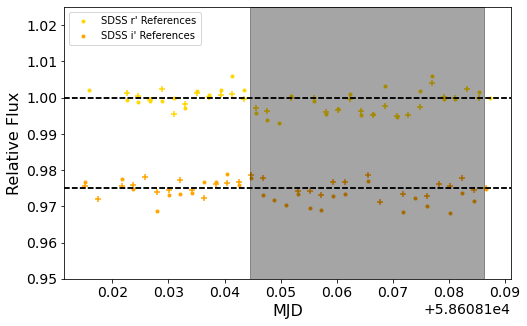

In [783]:
print('\n >>> Starting plots...')

#flux
fig_all_flux_transit = plt.figure(figsize=(8,5))
ax_all_flux_transit = fig_all_flux_transit.add_subplot(1, 1, 1)

for i,filt in enumerate(filt_list):
    result_filter = "*_"+str(filt)+"_*.result"
    res_files = sorted(glob.glob(os.path.join(results_direc, result_filter)))
            
    #time vs airmass
    fig_time_airmass = plt.figure(figsize=(8,5))
    ax_time_airmass = fig_time_airmass.add_subplot(1, 1, 1)
    
    #flux
    fig_flux_airmass = plt.figure(figsize=(8,5))
    ax_flux_airmass = fig_flux_airmass.add_subplot(1, 1, 1)
    
    fig_flux_time = plt.figure(figsize=(8,5))
    ax_flux_time = fig_flux_time.add_subplot(1, 1, 1)
    
    fig_flux_transit = plt.figure(figsize=(8,5))
    ax_flux_transit = fig_flux_transit.add_subplot(1, 1, 1)
    
    flux_ref_array = []
    
    for ff,rname in enumerate(res_files):
        with open(rname) as f:
            lines = f.readlines()
            image = [line.split()[0] for line in lines]
            ids = [line.split()[1] for line in lines]
            filts = [line.split()[2] for line in lines]
            otime_mjd = [float(line.split()[3]) for line in lines]
            xairmass = [float(line.split()[4]) for line in lines]
            exptime = [float(line.split()[5]) for line in lines]
            flux = [float(line.split()[6]) for line in lines]
            epadu = [float(line.split()[7]) for line in lines]
                        
            final_flux = flux
            
            #time vs airmass
            ax_time_airmass.scatter(otime_mjd, xairmass, c=color_array[-i])
            
            #flux
            ax_flux_airmass.scatter(xairmass, final_flux, c=color_array[int(ids[0])-2])
            ax_flux_time.scatter(otime_mjd, final_flux, c=color_array[int(ids[0])-2])
            
            if int(ids[0]) == 1:
                flux_star = np.asarray(final_flux)

            else:
                flux_ref = np.asarray(final_flux)
                
                rel_flux = [(s-r)/r+1.0 for s,r in zip(flux_star,flux_ref)]

                mjd_keep_flux, flux_keep = remove_outliers(otime_mjd, rel_flux, 
                                                           sigma=2.0)
                
                for j in range(4):
                    mjd_keep_flux, flux_keep = remove_outliers(mjd_keep_flux, flux_keep, 
                                                               sigma=2.0)
                    j += 1

                out_of_transit_flux = np.append(flux_keep[0:10], flux_keep[-1:])
                out_of_transit_mjd_flux = np.append(mjd_keep_flux[0:10], 
                                                    mjd_keep_flux[-1:])

                c_flux = np.polyfit(out_of_transit_mjd_flux, out_of_transit_flux, 1)

                fit_flux = flux_keep / (c_flux[1] + 
                                        c_flux[0]*mjd_keep_flux)
                
                out_of_transit_flux = np.append(fit_flux[0:10], fit_flux[-1:])
                out_of_transit_mjd_flux = np.append(mjd_keep_flux[0:10], 
                                                    mjd_keep_flux[-1:])

                c_flux = np.polyfit(out_of_transit_mjd_flux, out_of_transit_flux, 2)

                fit_flux = fit_flux / (c_flux[2] + 
                                        c_flux[1]*mjd_keep_flux + 
                                        c_flux[0]*mjd_keep_flux**2.0)

                ax_flux_transit.scatter(mjd_keep_flux, fit_flux, 
                                        c=color_array[int(ids[0])-2], 
                                        label='Reference #'+str(int(ids[0])-1))
                ax_flux_transit.axhline(y=1.00, c='k', ls='--')
                ax_flux_transit.axvspan(transit_start, transit_end, alpha=0.1, color='k')
                
                if (int(ids[0])-1) == 1:
                    lab = "SDSS "+str(filt)+"' References"
                else:
                    lab = ""
                    
                ax_all_flux_transit.scatter(mjd_keep_flux, fit_flux-depth/20.0*i,
                                            c=color_array[sdss_array.index(filt)], 
                                            marker=marker_array[int(ids[0])-2], 
                                            label=lab)
                ax_all_flux_transit.axhline(y=1.00-depth/20.0*i, c='k', ls='--')
                ax_all_flux_transit.axvspan(transit_start, transit_end, alpha=0.1, color='k')
        
    #time vs airmass
    ax_time_airmass.set_xlabel('MJD', fontsize=16)
    ax_time_airmass.set_ylabel('Airmass', fontsize=16)
    ax_time_airmass.invert_yaxis()
    plt.tight_layout()
    fig_time_airmass.savefig(os.path.join(results_direc,'time_x_'+str(filt)+'.png'),
                             dpi=200)

    #flux
    ax_flux_airmass.set_xlabel('Airmass', fontsize=16)
    ax_flux_airmass.set_ylabel('Instrumental Flux', fontsize=16)
    plt.tight_layout()
    fig_flux_airmass.savefig(os.path.join(results_direc,'flux_x_'+str(filt)+'.png'),
                             dpi=200)

    ax_flux_time.set_xlabel('MJD', fontsize=16)
    ax_flux_time.set_ylabel('Instrumental Flux', fontsize=16)
    plt.tight_layout()
    fig_flux_time.savefig(os.path.join(results_direc,'flux_time_'+str(filt)+'.png'),
                          dpi=200)
    
    ax_flux_transit.set_xlabel('MJD', fontsize=16)
    ax_flux_transit.set_ylabel('Relative Flux', fontsize=16)
    ax_flux_transit.set_ylim(1.00-depth/20.0,1.00+depth/20.0)
    ax_flux_transit.legend()
    plt.tight_layout()
    fig_flux_transit.savefig(os.path.join(results_direc,'transit_'+str(filt)+'.png'),
                             dpi=200)

ax_all_flux_transit.set_xlabel('MJD', fontsize=16)
ax_all_flux_transit.set_ylabel('Relative Flux', fontsize=16)
ax_all_flux_transit.set_ylim(1.00-depth/20.0*i-depth/20.0,1.00+depth/20.0)
ax_all_flux_transit.legend()
plt.tight_layout()
fig_all_flux_transit.savefig(os.path.join(results_direc,'transits_flux.png'),
                             dpi=200)

plt.close()
plt.close()
plt.close()
plt.close()
plt.close()
plt.close()
plt.close()
plt.close()